# Assignment 3
ES15BTECH11002

## Base class

In [65]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

num_chars = 256

class RNN:

    def __init__(self, num_hidden):

        self.num_hidden = num_hidden

        #input to hidden
        self.U = np.random.uniform(-np.sqrt(1./num_chars), np.sqrt(1./num_chars), (num_hidden, num_chars))
        #hidden to output
        self.V = np.random.uniform(-np.sqrt(1./num_hidden), np.sqrt(1./num_hidden), (num_chars, num_hidden))
        #recurrent connection in the hidden
        self.W = np.random.uniform(-np.sqrt(1./num_hidden), np.sqrt(1./num_hidden), (num_hidden, num_hidden))
    
    #cross entropy loss
    def loss(self, x):
        N = len(x)
        x = x[0:len(x)-1]
        y = x[1:len(x)]
        o, h = self.forward_propagation(x)
        correct_word_predictions = o[np.arange(len(y)), y]
        L = -1 *np.sum(np.log(correct_word_predictions))
        return L/N

    def forward_propagation(self, x, temp=1):
        T = len(x)

        # we need one extra hidden, we initialize all to zero and save them for later
        hidden = np.zeros((T+1, self.num_hidden))
        hidden[-1] = np.zeros(self.num_hidden)

        # we set T outputs to 0 and save them for later 
        out = np.zeros((T, num_chars))

        #computing forward prop
        for t in np.arange(T):
            hidden[t] = np.tanh(self.U[:,x[t]] + np.dot(self.W, hidden[t-1]))
            out[t] = softmax(np.dot(self.V, hidden[t]), temp)
        return out, hidden
    
    def bptt(self, x, y):
        T = len(y)
        # Perform forward propagation
        o, h = self.forward_propagation(x)
        # We accumulate the gradients in these variables
        dLdU = np.zeros(self.U.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        
        delta_out = o
        delta_out[np.arange(len(y)),y] -= 1
        # For each output backwards...
        for t in np.arange(T)[::-1]:
            dLdV += np.outer(delta_out[t], h[t].T)
            # Initial delta calculation: dL/dz
            delta_t = np.dot(self.V.T, delta_out[t]) * (1 - (h[t] ** 2))
            # Backpropagation through time (for at most self.bptt_truncate steps)
            for step in np.arange(max(0, t), t+1)[::-1]:
                # Add to gradients at each previous step
                dLdW += np.outer(delta_t, h[step-1])
                dLdU[:,x[step]] += delta_t
                # Update delta for next step dL/dz at t-1
                delta_t = np.dot(self.W.T, delta_t) * (1 - (h[step-1] ** 2))
        return dLdU, dLdV, dLdW
    
    def predict(self, x, temp=1):
        out, hidden_states = self.forward_propagation(x, temp)
        ascii_number = np.argmax(out[-1])
        return ascii_number

    def sgd_step(self, x, y, lr):
        dLdU, dLdV, dLdW = self.bptt(x,y)

        self.U -= lr * dLdU
        self.V -= lr * dLdV
        self.W -= lr * dLdW


### Function to plot 

In [66]:
def graph(toplot, labels, title, xlabel, ylabel, no_epoch):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    for i in range(len(toplot)):
        plt.plot(no_epoch, toplot[i], label = labels[i])
        
    plt.legend(loc = 'best')
    plt.show()

### Training Method

In [67]:
def train(model, x, lr, sequence_len, num_epochs, print_freq, breakpoint = False):
    train_loss = []
    no_epoch = []
    for epoch in range(1,num_epochs+1):
        i = 0
        no_epoch += [epoch]
        trainloss = model.loss(x[:1000])
        train_loss += [trainloss]
                    
        while (i+1+sequence_len) < len(x):
            model.sgd_step(x[i:i+sequence_len],x[i+1:i+1+sequence_len], lr)
            i += sequence_len
            
        if epoch % print_freq == 0:    
            print time.strftime("%Y-%m-%d %H:%M:%S")
            print ('\tepoch #%d: \tloss = %f' %(epoch, trainloss))
            if(breakpoint):
                text = generate(model, start = ord('T'), length = 100, temperature = 1, sequence_len = 50)
                print 'Generated text for epoch', epoch
                display(text)
                
    toplot = [train_loss]
    labels = ['Training loss']
    graph(toplot, labels, 'Training Loss vs epochs', 'epochs', 'Training Loss', no_epoch)

### Softmax with temperature

In [68]:
def softmax(a,temp):          # softmax with temperature
    numer = np.exp(a/temp)
    out = numer / numer.sum()
    return out

# 1


### Method to read file 

In [69]:
def read_file(filename):
    
    with open(filename, 'rb') as f:
        x = f.read()
    x_train = [ord(letter) for letter in x]
    unique = len(set(x))
    print ('There are %d unique characters\n' %unique)
    return x_train

### Method to generate text

In [70]:
def generate(model, start, length, temperature, sequence_len):  
    text = []
    text.append(start)

    for i in range(length-1):
        begin = max(0, len(text)-sequence_len)
        end = len(text)
        next_char = model.predict(text[begin:end], temperature)
        text.append(next_char)
    return text

### Method to display text

In [71]:
def display(text):
    
    print ('\nGenerating text of length %d' %len(text))
    gen = [str(chr(x)) for x in text]     # convert ascii number to corresponding character

    #join list of chars and print
    print 'Generated text: '
    print ''.join(gen)

    print "\ndone!"

### Hyperparameters

In [72]:
filename = 'novel.txt'
hidden_size = 100
learning_rate = 0.01
num_epochs = 24
print_freq = 4


__________----------------------------------------------------------------------------------------------___________


## 2b

### 2b i) and ii)

In [73]:
net = RNN(hidden_size)

In [74]:
start = ord('l')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

There are 98 unique characters

Training with
hidden_size = 100, learning_rate = 0.010000, sequence_len = 50, num_epochs = 24

2018-04-26 23:39:11
	epoch #4: 	loss = 2.783400
Generated text for epoch 4

Generating text of length 100
Generated text: 
The not tear to the Project Gutenberg-tm anc to the Project Gutenberg-tm anc to the Project Gutenber

done!
2018-04-26 23:44:18
	epoch #8: 	loss = 2.570852
Generated text for epoch 8

Generating text of length 100
Generated text: 
The Project Gutenberg-tme to teme to teme to teme to teme to teme to teme to teme to teme to teme to

done!
2018-04-26 23:49:47
	epoch #12: 	loss = 2.566886
Generated text for epoch 12

Generating text of length 100
Generated text: 
The to mutenberg-tm eBooks and of the Project Gutenberg-tm eBooks to cup to the Project Gutenberg-tm

done!
2018-04-26 23:54:39
	epoch #16: 	loss = 2.506994
Generated text for epoch 16

Generating text of length 100
Generated text: 
The Project Gutenbergerg-tm eBooks to to aroouted to 

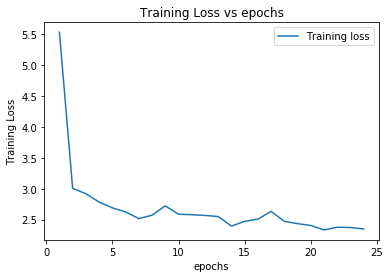

In [75]:
x = read_file(filename)

print 'Training with'
print ('hidden_size = %d, learning_rate = %f, sequence_len = %d, num_epochs = %d\n' \
%(hidden_size, learning_rate, sequence_len, num_epochs))


train(net, x, learning_rate, sequence_len, num_epochs, print_freq, breakpoint = True)



In [78]:
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)


Generating text of length 100
Generated text: 
l to to to te ton eroject Gutenberg to to te ton eroject Gutenberg to to te ton eroject Gutenberg to

done!


## Report

### 2b iii)

#### Temp1

##### text1

In [85]:
start = ord('a')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [86]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 1, start letter = 97


Generating text of length 100
Generated text: 
at to to te to te to tepporm terore to hears that to to te to te to tepporm terore to hears that to 

done!


##### text2

In [87]:
start = ord('b')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [88]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 1, start letter = 98


Generating text of length 100
Generated text: 
berg-tm eBooks any the Project Gutenberg to to te ton eroject Gutenberg to to te ton eroject Gutenbe

done!


##### text3

In [89]:
start = ord('h')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [90]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 1, start letter = 104


Generating text of length 100
Generated text: 
hich the Project Gutenberg to to te ton eroject Gutenberg to to te ton eroject Gutenberg to to te to

done!


##### text4

In [91]:
start = ord('i')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [92]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 1, start letter = 105


Generating text of length 100
Generated text: 
it to to te to te to tepporm terore to hears that to to te to te to tepporm terore to hears that to 

done!


##### text5

In [93]:
start = ord('n')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [94]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 1, start letter = 110


Generating text of length 100
Generated text: 
nteraring to to te to te to tepporm terore to hears that to to te to te to tepporm terore to hears t

done!


#### Temp2

##### text1

In [95]:
start = ord('v')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 10       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [96]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 10, start letter = 118


Generating text of length 100
Generated text: 
ve to to te ton eroject Gutenberg to to te ton eroject Gutenberg to to te ton eroject Gutenberg to t

done!


##### text2

In [97]:
start = ord('r')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 10       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [98]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 10, start letter = 114


Generating text of length 100
Generated text: 
rgate to tee to to te to tepporm terore to hears that to to te to te to tepporm terore to hears that

done!


##### text3

In [99]:
start = ord('u')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 10       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [100]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 10, start letter = 117


Generating text of length 100
Generated text: 
ute to te to te to tepporm terore to hears that to to te to te to tepporm terore to hears that to to

done!


##### text4

In [101]:
start = ord('t')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 10       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [102]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 10, start letter = 116


Generating text of length 100
Generated text: 
ter to tee to to te to tepporm terore to hears that to to te to te to tepporm terore to hears that t

done!


##### text5

In [103]:
start = ord('q')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 10       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [104]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 10, start letter = 113


Generating text of length 100
Generated text: 
qutenberg-tm eBork to to te to te to tepporm terore to hears that to to te to te to tepporm terore t

done!


#### Temp3

##### text1

In [105]:
start = ord('f')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 100       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [106]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 100, start letter = 102


Generating text of length 100
Generated text: 
form the Prom enorusion to to te to teppor to to te to tepporm to te to te to tepporm terore to hear

done!


##### text2

In [107]:
start = ord('p')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 100       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [108]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 100, start letter = 112


Generating text of length 100
Generated text: 
parrest the Project Gutenberg to to te ton eroject Gutenberg to to te ton eroject Gutenberg to to te

done!


##### text3

In [109]:
start = ord('x')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 100       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [110]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 100, start letter = 120


Generating text of length 100
Generated text: 
xat to to te to te to tepporm terore to hears that to to te to te to tepporm terore to hears that to

done!


##### text4

In [111]:
start = ord('y')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 100       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [112]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 100, start letter = 121


Generating text of length 100
Generated text: 
y the Project Gutenberg to to te ton eroject Gutenberg to to te ton eroject Gutenberg to to te ton e

done!


##### text5

In [113]:
start = ord('z')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 100       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [114]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 100, start letter = 122


Generating text of length 100
Generated text: 
zat to to te ton eroject Gutenberg to to te ton eroject Gutenberg to to te ton eroject Gutenberg to 

done!


## Report

## 2c

### i)



### Doubling hidden layer size

In [115]:
net2 = RNN(hidden_size*2)

In [116]:
start = ord('l')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

There are 98 unique characters

Training with
hidden_size = 100, learning_rate = 0.010000, sequence_len = 50, num_epochs = 24

2018-04-27 07:07:02
	epoch #4: 	loss = 3.120729
Generated text for epoch 4

Generating text of length 100
Generated text: 
Tho ore tor exoor teout to searort to texss texs arout nowst of
arout tonted to he ore wonted to he 

done!
2018-04-27 07:13:41
	epoch #8: 	loss = 2.798043
Generated text for epoch 8

Generating text of length 100
Generated text: 
The stark tone. terolect Gurected to suar and sor to
hroject Gutenberg Lew to to
Seat eBont in looke

done!
2018-04-27 07:20:46
	epoch #12: 	loss = 2.816450
Generated text for epoch 12

Generating text of length 100
Generated text: 
The Project Gutenberg-tm efook to

Put now arcorrite to the Uroject Gutenberg-tm sut to
essorg/em to

done!
2018-04-27 07:27:34
	epoch #16: 	loss = 2.841540
Generated text for epoch 16

Generating text of length 100
Generated text: 
The tons and pon and emoor hecher to hearly with helu

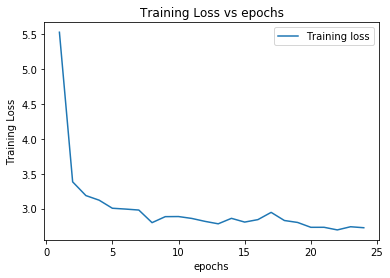

In [117]:
x = read_file(filename)

print 'Training with'
print ('hidden_size = %d, learning_rate = %f, sequence_len = %d, num_epochs = %d\n' \
%(hidden_size, learning_rate, sequence_len, num_epochs))


train(net2, x, learning_rate, sequence_len, num_epochs, print_freq, breakpoint = True)



In [118]:
gen_text = generate(net2, start, gen_length, temperature, sequence_len)
display(gen_text)


Generating text of length 100
Generated text: 
licutent rew the Prosecee sal to hear that eows to hear about erooks to searlate of the tort in luw 

done!


#### Temp1

##### text1

In [119]:
start = ord('l')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [120]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net2, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 1, start letter = 108


Generating text of length 100
Generated text: 
licutent rew the Prosecee sal to hear that eows to hear about erooks to searlate of the tort in luw 

done!


#### Temp2

##### text1

In [121]:
start = ord('a')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 10       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [122]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net2, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 10, start letter = 97


Generating text of length 100
Generated text: 
at sew to suar arout eroject Gutenberg-tm eBooks to cews erout eew the Projecreture wew the to the P

done!


#### Temp3

##### text1

In [123]:
start = ord('p')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 100       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [124]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net2, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 100, start letter = 112


Generating text of length 100
Generated text: 
plitere tor tenect Gutenberg-tm teare of hear and per texe sote and that enwite to heary to the Proj

done!


### Halving hidden layer size

In [125]:
net5 = RNN(hidden_size/2)

In [126]:
start = ord('l')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

There are 98 unique characters

Training with
hidden_size = 100, learning_rate = 0.010000, sequence_len = 50, num_epochs = 24

2018-04-27 07:43:20
	epoch #4: 	loss = 2.710861
Generated text for epoch 4

Generating text of length 100
Generated text: 
That or to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to

done!
2018-04-27 07:45:53
	epoch #8: 	loss = 2.448008
Generated text for epoch 8

Generating text of length 100
Generated text: 
The Project Gutenberg-tm to to to to to to to to to to to to to to to to to to to to to to to to to 

done!
2018-04-27 07:48:20
	epoch #12: 	loss = 2.412812
Generated text for epoch 12

Generating text of length 100
Generated text: 
The Project Gutenberg-tm to to to to to to to to to to to to to to to to to to to to to to to to to 

done!
2018-04-27 07:50:38
	epoch #16: 	loss = 2.393405
Generated text for epoch 16

Generating text of length 100
Generated text: 
Th explice to to to to to to to to to to to to to to 

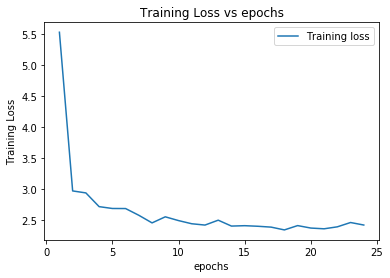

In [127]:
x = read_file(filename)

print 'Training with'
print ('hidden_size = %d, learning_rate = %f, sequence_len = %d, num_epochs = %d\n' \
%(hidden_size, learning_rate, sequence_len, num_epochs))


train(net5, x, learning_rate, sequence_len, num_epochs, print_freq, breakpoint = True)



In [128]:
gen_text = generate(net5, start, gen_length, temperature, sequence_len)
display(gen_text)


Generating text of length 100
Generated text: 
lubed to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to t

done!


#### Temp1

##### text1

In [129]:
start = ord('l')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [130]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net5, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 1, start letter = 108


Generating text of length 100
Generated text: 
lubed to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to t

done!


#### Temp2

##### text1

In [131]:
start = ord('a')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 10       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [132]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net5, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 10, start letter = 97


Generating text of length 100
Generated text: 
ark of the Project Gutenberg-tm to to to to to to to to to to to to to to to to to to to to to to to

done!


#### Temp3

##### text1

In [133]:
start = ord('p')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 100       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [134]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net5, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 100, start letter = 112


Generating text of length 100
Generated text: 
part. Te hour to to to to to to to to to to to to to to to to to to to to to to to to to to to to to

done!


## Observations

### 2c ii)

### Doubling sequence

In [135]:
net22 = RNN(hidden_size)

In [136]:
start = ord('l')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50*2

There are 98 unique characters

Training with
hidden_size = 100, learning_rate = 0.010000, sequence_len = 100, num_epochs = 24

2018-04-27 07:58:46
	epoch #4: 	loss = 2.778732
Generated text for epoch 4

Generating text of length 100
Generated text: 
Thave of compling the Project Gutenberg-tm enformed wo haw  of the Project Gutenberg-tm enformed wo 

done!
2018-04-27 08:02:18
	epoch #8: 	loss = 2.388101
Generated text for epoch 8

Generating text of length 100
Generated text: 
Thout the Project Gutenberg-tm ed the Project Gutenberg-tm ed the Project Gutenberg-tm ed the Projec

done!
2018-04-27 08:05:48
	epoch #12: 	loss = 2.426654
Generated text for epoch 12

Generating text of length 100
Generated text: 
Thow any part including donation and he Por copped the Project Gutenberg-tm and donation and he Por 

done!
2018-04-27 08:09:18
	epoch #16: 	loss = 2.369538
Generated text for epoch 16

Generating text of length 100
Generated text: 
Thowh or he Por the Project Gutenberg to not protect

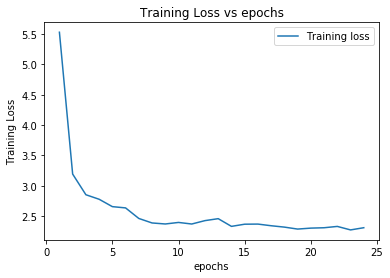

In [137]:
x = read_file(filename)

print 'Training with'
print ('hidden_size = %d, learning_rate = %f, sequence_len = %d, num_epochs = %d\n' \
%(hidden_size, learning_rate, sequence_len, num_epochs))


train(net22, x, learning_rate, sequence_len, num_epochs, print_freq, breakpoint = True)



In [138]:
gen_text = generate(net22, start, gen_length, temperature, sequence_len)
display(gen_text)


Generating text of length 100
Generated text: 
ly any proarm to new to nent of the Project Gutenberg-tm archive Foundation the Project Gutenberg Li

done!


#### Temp1

##### text1

In [139]:
start = ord('r')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [140]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net22, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 1, start letter = 114


Generating text of length 100
Generated text: 
rate to prote not colations are so the Project Gutenberg uncepprrat of the Project Gutenberg-tm arch

done!


#### Temp2

##### text1

In [141]:
start = ord('s')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 10       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [142]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net22, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 10, start letter = 115


Generating text of length 100
Generated text: 
s cor the Project Gutenberg uncepprrance the Project Gutenberg and donation archre so no rou copyrig

done!


#### Temp3

##### text1

In [143]:
start = ord('t')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 100       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [144]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net22, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 100, start letter = 116


Generating text of length 100
Generated text: 
to not promice or copyright not colect Gutenberg-tm aroject Gutenberg and donation archre so no rou 

done!


### Halving sequence

In [145]:
net25 = RNN(hidden_size)

In [146]:
start = ord('l')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50/2

There are 98 unique characters

Training with
hidden_size = 100, learning_rate = 0.010000, sequence_len = 25, num_epochs = 24

2018-04-27 08:20:04
	epoch #4: 	loss = 2.885550
Generated text for epoch 4

Generating text of length 100
Generated text: 
The Project Gutenberg-tm terserger to her to hermed to her to her to her to her to hermert to her to

done!
2018-04-27 08:23:39
	epoch #8: 	loss = 2.702681
Generated text for epoch 8

Generating text of length 100
Generated text: 
The Project Gutenberg-tm eep to the Project Gutenberg-tm eep to the Project Gutenberg-tm eep to the 

done!
2018-04-27 08:27:32
	epoch #12: 	loss = 2.594439
Generated text for epoch 12

Generating text of length 100
Generated text: 
The hou he how arl out to ter to ters arowect Gutenberg-tm to here to ter to ter to ter to ter to te

done!
2018-04-27 08:31:40
	epoch #16: 	loss = 2.504579
Generated text for epoch 16

Generating text of length 100
Generated text: 
The her to terutenberg-tm to of the Project Gutenberg

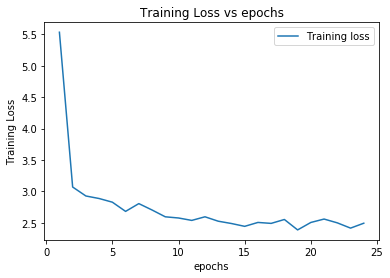

In [147]:
x = read_file(filename)

print 'Training with'
print ('hidden_size = %d, learning_rate = %f, sequence_len = %d, num_epochs = %d\n' \
%(hidden_size, learning_rate, sequence_len, num_epochs))


train(net25, x, learning_rate, sequence_len, num_epochs, print_freq, breakpoint = True)



In [148]:
gen_text = generate(net25, start, gen_length, temperature, sequence_len)
display(gen_text)


Generating text of length 100
Generated text: 
lite to he how to her to her to her to her to her to her to her to her to her to her to her to her t

done!


#### Temp1

##### text1

In [149]:
start = ord('l')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 1       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [150]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net25, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 1, start letter = 108


Generating text of length 100
Generated text: 
lite to he how to her to her to her to her to her to her to her to her to her to her to her to her t

done!


#### Temp2

##### text1

In [151]:
start = ord('a')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 10       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [152]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net25, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 10, start letter = 97


Generating text of length 100
Generated text: 
ar tew the Project Gutenberg-tm a cou tee how to her the Project Gutenberg-tm a cou tee how to her t

done!


#### Temp3

##### text1

In [153]:
start = ord('r')      #start character of generated text                
gen_length = 100       # number of characters to generate
temperature = 100       # temperature to bias the predictions to most probable or to uniformly predict every char 
sequence_len = 50

In [154]:

print ('Generated text of length = %d, temperature = %d, start letter = %d\n'\
        %(gen_length, temperature, start)
      )
gen_text = generate(net25, start, gen_length, temperature, sequence_len)
display(gen_text)

Generated text of length = 100, temperature = 100, start letter = 114


Generating text of length 100
Generated text: 
rg Lou tee how to her about the Project Gutenberg-tm a cou tee how to her the Project Gutenberg-tm a

done!


## Observations

## Refrence taken from:

http://wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/

# 2a

## Forward

In [ ]:


st = tanh(U*xt + W*st-1)
ot = softmax(Vst)


## Backward 